## Beamforming Antenna Design

Created on Fri Feb 18 1:45:42 2020  
Author: Aaron Diebold

Convert everything to Cartesian unit vectors before applying functions.  
Construct every vector as size (n X 3)  
Spherical vectors (r, theta, phi) with theta polar angle from z axis, phi azimuthal from x axis.

In [ ]:
# -*- coding: utf-8 -*-

In [1]:
import numpy as np
import metasurface_functions_az_el as mf
from scipy import special as sp
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import scipy.io
from matplotlib import collections  as mc
from matplotlib import transforms
import mpl_toolkits.mplot3d.axes3d as axes3d
fs = 17
font = {'size' : fs, 'family' : 'Times New Roman'}
matplotlib.rc('font', **font)

## General Parameters

In [2]:
fc = 11.2E9
bw = .5E9
f0 = np.linspace(fc-bw, fc+bw, 5001)
f = np.linspace(fc-bw, fc+bw, 51)
fc_indx = np.floor(f.size/2).astype(np.int32)
F_0, F = np.meshgrid(f0, f, indexing='ij')
c = 3.0E8
mu0 = 4.0*np.pi*10**-7
eps0 = 8.85*10**-12
Z0 = np.sqrt(mu0/eps0)
lam = c/f
k = 2*np.pi/lam
omega = 2*np.pi*f

## Parameters

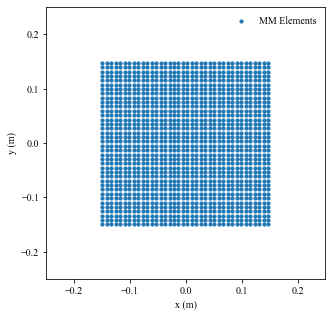

In [3]:
F_damp = (1.5E-3)**3        # Damping parameter
Q = 20                      # Element Q
Gamma = (2*np.pi*F_0)/(2*Q)
alpha_dict = (F_damp*(2*np.pi*F)**2)/((2*np.pi*F_0)**2 - (2*np.pi*F)**2 + 1j*Gamma*(2*np.pi*F))    # Polarizability dictionary for Euclidean modulation

l_ap = .3               # Aperture size
#element_spacing = lam[fc_indx]/2
element_spacing = 0.3*lam[fc_indx]

E_1 = 1
theta_1 = 45 * np.pi/180            # Steered beam theta
phi_1 = 0 * np.pi/180             # Steered beam phi

## Define aperture parameters
x = np.arange(-l_ap/2, l_ap/2, element_spacing)
y = np.arange(-l_ap/2, l_ap/2, element_spacing)
X, Y = np.meshgrid(x, y, indexing='ij')

r_0 = np.transpose(np.array([0, 0, 0]))        # Feed location
X_ppwg = X
Y_ppwg = Y
Z_ppwg = np.zeros(Y_ppwg.shape)
r_i_ppwg = np.transpose(np.array([np.reshape(X_ppwg, -1), np.reshape(Y_ppwg, -1), np.reshape(Z_ppwg, -1)]))

## Cylindrical coordinates
r_a = np.sqrt((X_ppwg-r_0[0])**2 + (Y_ppwg-r_0[1])**2)
theta_a = np.arctan2(Y_ppwg, X_ppwg)

k_b_1_spherical = np.transpose(np.array([k[fc_indx], 0, 0])[:,None])
k_b_1_cartesian = mf.spherical_to_cartesian_vector(k_b_1_spherical, theta_1, phi_1)

E_1_spherical = np.transpose(np.array([0, 1, 0])[:,None])
E_1_cartesian = mf.spherical_to_cartesian_vector(E_1_spherical, theta_1, phi_1)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(False)
ax.scatter(X_ppwg, Y_ppwg, 10, label='MM Elements')
ax.legend(frameon=False)
ax.set_xlim(-l_ap/2-.1, l_ap/2+.1)
ax.set_ylim(-l_ap/2-.1, l_ap/2+.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

## Define Element Lattices

In [4]:
nu_ppwg = np.transpose(1/np.sqrt(2) * np.array([1, 1, 0])[:,None])
mu_ppwg = np.transpose(1/np.sqrt(2) * np.array([1, -1, 0])[:,None])
nu_ppwg_cartesian = mf.cylindrical_to_cartesian_vector(
   nu_ppwg,
   np.reshape(theta_a, -1))
mu_ppwg_cartesian = mf.cylindrical_to_cartesian_vector(
   mu_ppwg,
   np.reshape(theta_a, -1))

# nu_ppwg_cartesian = np.transpose(np.array([0, 0, 1])[:,None])
# mu_ppwg_cartesian = np.transpose(np.array([0, 0, 1])[:,None])

# nu_ppwg_cartesian = np.transpose(np.array([np.random.rand(X_ppwg.size)-0.5, np.zeros(X_ppwg.size), np.random.rand(X_ppwg.size)-0.5]))
# nu_ppwg_cartesian = nu_ppwg_cartesian/np.sqrt(np.sum(nu_ppwg_cartesian**2, 1, keepdims=True))
# mu_ppwg_cartesian = np.transpose(np.array([np.ones(X_ppwg.size), np.zeros(X_ppwg.size), np.zeros(X_ppwg.size)]))
# mu_ppwg_cartesian = mu_ppwg_cartesian - ( np.sum(mu_ppwg_cartesian * nu_ppwg_cartesian, 1, keepdims=True)/np.sum(nu_ppwg_cartesian * nu_ppwg_cartesian, 1, keepdims=True) ) * nu_ppwg_cartesian
# mu_ppwg_cartesian = mu_ppwg_cartesian/np.sqrt(np.sum(mu_ppwg_cartesian**2, 1, keepdims=True))


## Design PPWG antenna

Modulation Types:  
0 - Ideal, unconstrained polarizabilities  
1 - Euclidean modulation  
2 - David's phase modulation  
3 - Patrick's phase modulation  
4 - Matrix inversion method  

In [5]:
n_g = 2.2              # Waveguide index
beta_m = n_g * 2*np.pi*fc/c
#H_f_ppwg = np.transpose(np.array([np.zeros(X_ppwg.size), np.reshape(sp.hankel2(1, beta_m*r_a), -1), np.zeros(X_ppwg.size)]))
H_f_ppwg = np.transpose(np.array([np.zeros(X_ppwg.size), np.reshape(np.exp(-1j*beta_m*r_a), -1), np.zeros(X_ppwg.size)]))
H_f_ppwg_cartesian = mf.cylindrical_to_cartesian_vector(H_f_ppwg, np.reshape(theta_a, -1))
#H_f_ppwg_cartesian = np.transpose(np.array([np.zeros(X_ppwg.size), np.zeros(X_ppwg.size), np.reshape(np.exp(-1j*beta_m*r_i_ppwg[:,0]), -1)]))

n = np.transpose(np.array([0, 0, 1])[:,None])        # Aperture normal direction

## Select ideal polarizabilities and polarizabilities for Euclidean modulation
alpha_1_true_ppwg, alpha_2_true_ppwg, alpha_dict_ppwg, indx_1_ppwg, indx_2_ppwg = mf.compute_polarizabilities_beam(
    r_i_ppwg, H_f_ppwg_cartesian, k_b_1_cartesian, nu_ppwg_cartesian, mu_ppwg_cartesian,
    n, E_1_cartesian, element_spacing, k[fc_indx], alpha_dict, fc_indx)

## Compute surface currents for different polarizability mappings
modulation_type = 4

K_m_ppwg = mf.make_surface_currents(
                f[fc_indx], fc_indx, nu_ppwg_cartesian, mu_ppwg_cartesian, modulation_type, 
                alpha_1_true_ppwg, alpha_2_true_ppwg, alpha_dict_ppwg, indx_1_ppwg, indx_2_ppwg,
                element_spacing, H_f_ppwg_cartesian, theta_1, phi_1, r_i_ppwg, E_1_spherical)

## Omit positions close to feed
indx = np.where((np.abs(np.reshape(X, -1)-r_0[0])<1E-2) & (np.abs(np.reshape(Y, -1)-r_0[1])<1E-2))
K_m_ppwg[indx, 0] = 0
K_m_ppwg[indx, 1] = 0
K_m_ppwg[indx, 2] = 0

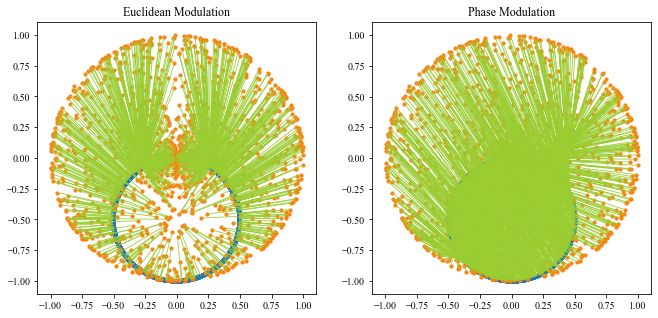

In [6]:
# alpha_lorentz1 = (-1j + np.exp(1j*np.angle(alpha_1_true_ppwg)))/2

phase_term1 = np.angle(alpha_1_true_ppwg)/2
alpha_lorentz1 = np.sin(phase_term1)*np.exp(-1j*phase_term1)
alpha_lorentz1 = alpha_lorentz1/np.amax(np.abs(alpha_lorentz1))

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(1, 2, 1)
ax.grid(False)
ax.scatter(np.real(alpha_dict_ppwg[:, fc_indx])/np.max(np.abs(alpha_1_true_ppwg)), np.imag(alpha_dict_ppwg[:, fc_indx])/np.max(np.abs(alpha_1_true_ppwg)), 10)
ax.scatter(np.real(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)), np.imag(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)), 10)
lines = np.transpose(np.array([(np.real(alpha_dict_ppwg[indx_1_ppwg, fc_indx]), np.imag(alpha_dict_ppwg[indx_1_ppwg, fc_indx])), (np.real(alpha_1_true_ppwg), np.imag(alpha_1_true_ppwg))]), (2,0,1))
lc = mc.LineCollection(lines/np.max(np.abs(alpha_1_true_ppwg)), linewidths=.8, colors='yellowgreen')
ax.add_collection(lc)
plt.title('Euclidean Modulation')

ax = fig.add_subplot(1, 2, 2)
ax.grid(False)
ax.scatter(np.real(alpha_lorentz1), np.imag(alpha_lorentz1), 10)
ax.scatter(np.real(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)), np.imag(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)), 10)
lines = np.transpose(np.array([(np.real(alpha_lorentz1), np.imag(alpha_lorentz1)), (np.real(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)), np.imag(alpha_1_true_ppwg)/np.max(np.abs(alpha_1_true_ppwg)))]), (2,0,1))
lc = mc.LineCollection(lines, linewidths=.8, colors='yellowgreen')
ax.add_collection(lc)
plt.title('Phase Modulation')
plt.show()

## Propagate PPWG currents to far field

In [22]:
# # FFT-BASED PROPAGATION

# N = 200
# Theta_far, Phi_far, H = mf.fft_prop_from_magnetic_currents(K_m_ppwg, x, y, k[fc_indx], N)

# H_int = np.abs(np.sum(H * np.conjugate(H), 1)).astype(np.float32)
# P_tot = ((np.pi**2)/(Theta_far.shape[0]*Theta_far.shape[1]))*np.sum(H_int * np.sin(np.reshape(Theta_far, -1)))
# directivity = 10*np.log10(4*np.pi*np.amax(H_int)/P_tot)

# H_plot = np.reshape(H_int, (Theta_far.shape[0], Theta_far.shape[1]))

In [29]:
# NUMERICAL INTEGRATION PROPAGATION

N = 200
Theta_far, Phi_far = np.meshgrid(
        np.arange(0, np.pi/2, np.pi/N),
        np.arange(0, 2*np.pi, np.pi/N),
        indexing='ij')
H = mf.compute_FF_from_magnetic_currents(r_i_ppwg, K_m_ppwg, k[fc_indx], N)

H_int = np.abs(np.sum(H * np.conjugate(H), 1)).astype(np.float32)
H_int = H_int/np.amax(H_int)
P_tot = ((np.pi**2)/(Theta_far.shape[0]*Theta_far.shape[1]))*np.sum(H_int * np.sin(np.reshape(Theta_far, -1)))
directivity = 10*np.log10(4*np.pi*np.amax(H_int)/P_tot)

H_plot = np.reshape(np.abs(np.sum(H * np.conjugate(H), 1)), (Theta_far.shape[0], Theta_far.shape[1]))

In [17]:
print('Directivity = ', directivity)
print('Max Directivity = ', 10*np.log10(4*np.pi*(l_ap**2)/(lam[fc_indx]**2)))

Directivity =  29.400978813464995
Max Directivity =  31.976459093624598


## Plots

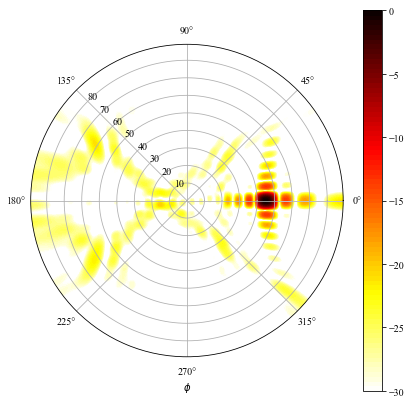

In [18]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(7,7))
cs = ax.contourf(Phi_far, Theta_far*180/np.pi, 10*np.log10(H_plot/np.amax(H_plot)), 
            np.linspace(-30, 0, 80), 
            cmap=plt.cm.hot_r)
ax.grid(True)
ax.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-30, 0, 7))
plt.xlabel('$\phi$')
#plt.ylabel(r'$\theta$')
plt.show()

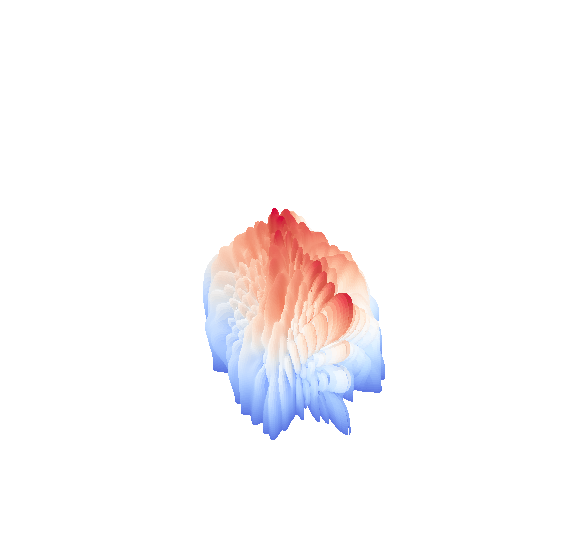

In [19]:
from matplotlib.colors import LightSource
from matplotlib import cm

theta, phi = np.linspace(0, np.pi/2, 100), np.linspace(0, 2*np.pi, 100)
THETA, PHI = np.meshgrid(theta, phi)
R = 10*np.log10(H_plot/np.amax(H_plot))
R = R-np.amin(R)
R_max = np.amax(R)
#R = H_plot/np.amax(H_plot)
X = R * np.sin(Theta_far) * np.cos(Phi_far)
Y = R * np.sin(Theta_far) * np.sin(Phi_far)
Z = R * np.cos(Theta_far)

ls = LightSource(270, 45)
rgb = ls.shade(Z, cmap=cm.coolwarm, vert_exag=0.5, blend_mode='soft')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z,
    rstride=1, cstride=1,
    linewidth=0, antialiased=False, alpha=1, 
    facecolors=rgb, shade=False)
ax.view_init(elev=50, azim=-30)
ax.set_xlim(-R_max, R_max)
ax.set_ylim(-R_max, R_max)
ax.set_zlim(0, R_max)
ax.grid(False)
plt.axis('off')
plt.show()

Text(0.5, 0, '$\\phi$')

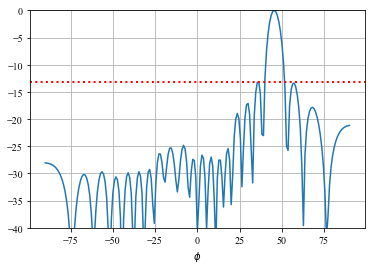

In [20]:
# PLOT REQUIRES PHI=0

test = np.concatenate((np.flip(H_plot[1:,np.floor(N).astype(np.int32)][:,None]), H_plot[:,0][:,None]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(True)
ax.plot(np.linspace(-90, 90, test.size), 10*np.log10(test/np.amax(test)))
plt.axhline(y=-13.26, color='r', linewidth=2, linestyle=':')
ax.set_ylim(-40, 0)
plt.xlabel(r'$\phi$')

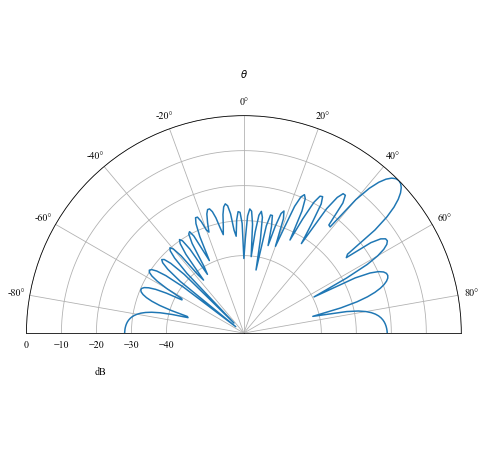

In [21]:
# PLOT REQUIRES PHI=0

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.plot(np.linspace(-np.pi/2, np.pi/2, test.size), 10*np.log10(test/np.amax(test)))
ax.set_thetalim(-np.pi/2, np.pi/2)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylabel('dB', rotation=0)
ax.yaxis.set_label_coords(0.17, 0.15)
ax.set_xlabel(r'$\theta$')
ax.xaxis.set_label_coords(0.5, 0.86)
ax.set_yticks([-40, -30, -20, -10, 0])
plt.show()

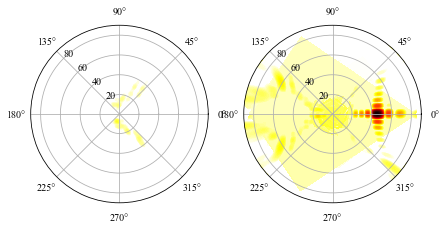

In [14]:
# H_circular = mf.spherical_to_circular_vector(H)
# H_right = np.reshape(np.abs(H_circular[:,0] * np.conjugate(H_circular[:,0])), (Theta_far.shape[0], Theta_far.shape[1]))
# H_left = np.reshape(np.abs(H_circular[:,1] * np.conjugate(H_circular[:,1])), (Theta_far.shape[0], Theta_far.shape[1]))

H_theta = np.reshape(np.abs(H[:,2] * np.conjugate(H[:,2])), (Theta_far.shape[0], Theta_far.shape[1]))
H_phi = np.reshape(np.abs(H[:,1] * np.conjugate(H[:,1])), (Theta_far.shape[0], Theta_far.shape[1]))

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(7,7))
cs = ax1.contourf(Phi_far, Theta_far*180/np.pi, 10*np.log10(H_theta/np.amax(np.abs(H * np.conjugate(H)))), 
            np.linspace(-30, 0, 80), 
            cmap=plt.cm.hot_r)
ax1.grid(True)
ax1.set_rlabel_position(135)
#fig.colorbar(cs, ticks=np.linspace(-30, 0, 7))
#plt.xlabel('$\phi$')
cs = ax2.contourf(Phi_far, Theta_far*180/np.pi, 10*np.log10(H_phi/np.amax(np.abs(H * np.conjugate(H)))), 
            np.linspace(-30, 0, 80), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
#fig.colorbar(cs, ticks=np.linspace(-30, 0, 7))
#plt.xlabel('$\phi$')
plt.show()

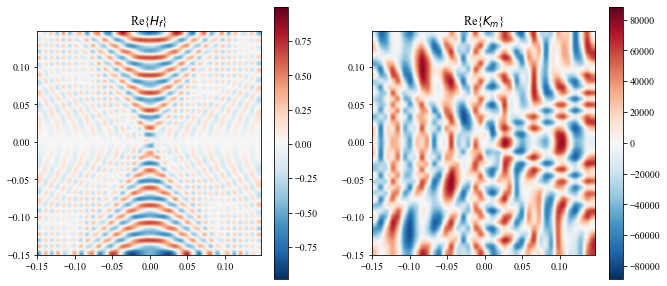

In [15]:
H_f_plot = np.real(np.reshape(H_f_ppwg_cartesian[:,0], (x.size, y.size)))
K_m_plot = np.real(np.reshape(K_m_ppwg[:,1], (x.size, y.size)))

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(np.transpose(H_f_plot), origin='lower', cmap=plt.cm.RdBu_r, interpolation='gaussian', extent=((x[0],x[-1],y[0],y[-1])))
plt.colorbar()
plt.title('Re{$H_f$}')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(np.transpose(K_m_plot), origin='lower', cmap=plt.cm.RdBu_r, interpolation='gaussian', extent=((x[0],x[-1],y[0],y[-1])))
plt.colorbar()
plt.title('Re{$K_m$}')
plt.show()